### libs and defs

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
import skrf.plotting as skplt
from skrf.data import ring_slot

# Load the S-parameter file
bjt = rf.Network('Sparam-partI.s2p', )

# Filter for 4 GHz
freq_idx = np.where(np.isclose(bjt.f, 4e9, atol=1e7))[0][0]
freq_point = bjt[freq_idx]

# Define a function to calculate the square of the absolute value
def sqabs(x): return np.square(np.absolute(x))



In [149]:
# show  the information of the network
bjt

2-Port Network: 'Sparam-partI',  1000000000.0-10000000000.0 Hz, 1002 pts, z0=[50.+0.j 50.+0.j]

In [150]:
# Plot the S-parameters
bjt.s


array([[[-0.04104089 -0.47832841j, -5.50944484+11.54821684j],
        [ 0.02946176 +0.0388533j ,  0.46110536 -0.42302339j]],

       [[-0.0423739  -0.47769787j, -5.48266481+11.54086655j],
        [ 0.02952472 +0.03888311j,  0.46016488 -0.42286343j]],

       [[-0.04370526 -0.47706372j, -5.45591399+11.53345673j],
        [ 0.02958772 +0.03891291j,  0.45922514 -0.42270164j]],

       ...,

       [[ 0.22735303 +0.75520054j,  1.15986575 -0.56881637j],
        [ 0.17707113 -0.04548957j,  0.03270696 +0.28213268j]],

       [[ 0.2295731  +0.75540952j,  1.15360045 -0.5716632j ],
        [ 0.17703684 -0.04605483j,  0.03391899 +0.28342886j]],

       [[ 0.23179333 +0.75561029j,  1.14733973 -0.57447565j],
        [ 0.17699978 -0.04662082j,  0.03514023 +0.28471871j]]],
      shape=(1002, 2, 2))

In [151]:
#show the frequency points
bjt.frequency.f_scaled

array([1.00000000e+09, 1.00230293e+09, 1.00461117e+09, ...,
       9.95409997e+09, 9.97702359e+09, 1.00000000e+10], shape=(1002,))

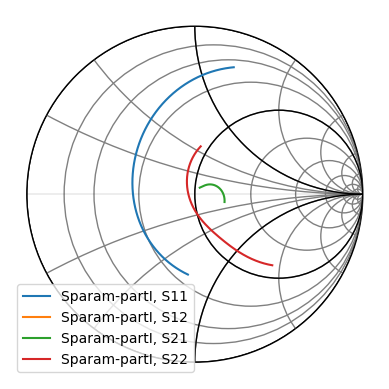

In [152]:
bjt.plot_s_smith()

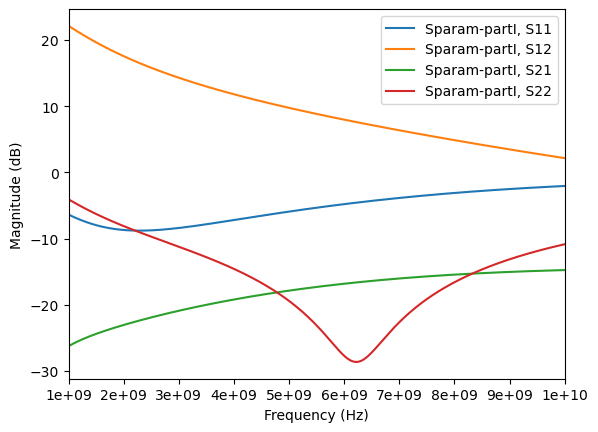

In [153]:
# plot the S-parameters in dB
bjt.plot_s_db()

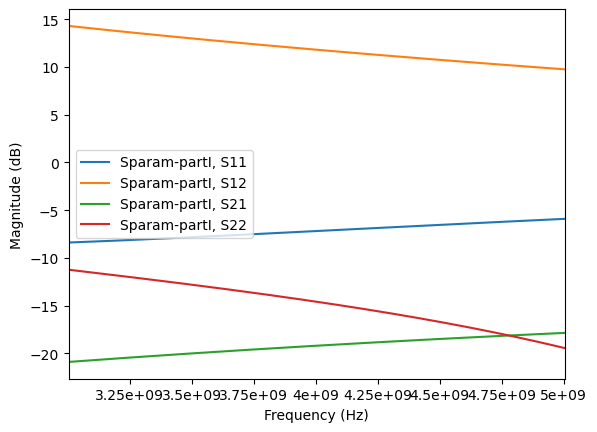

In [154]:
# plot the S-parameters in dB for the frequency range 3-5 GHz

bjt['3-5ghz'].plot_s_db()

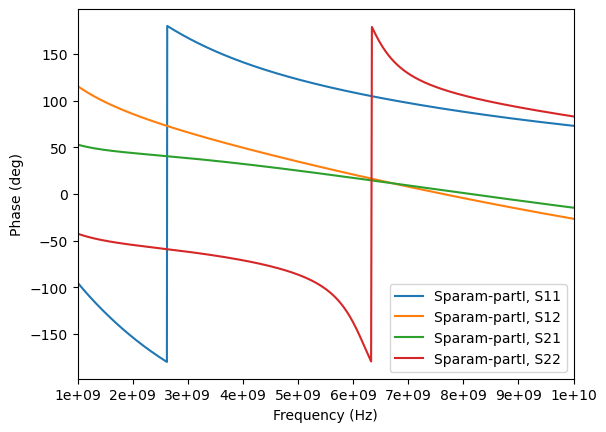

In [155]:
#plot phase of S-parameters in degrees
bjt.plot_s_deg()

### Bias

In [156]:
from sympy import * 
r1, r2,r3,r4,b,vbe,vce,vcc,ib,ic,ie = symbols('R_1 R_2 R_3 R_4 beta V_{BE} V_{CE} V_{CC} I_b I_C I_E')


r2  = 1e3
r4  = 100
vcc = 10
b   = 72.534
ic  = 9e-3
vbe = 1
vce = 5

ib  = ic/b
ie  = (b+1)*ib
eq1 = vcc - r3*ic-r4*ie-vce
vth = vcc*( r2/(r1+r2) )
rth = (r1*r2)/(r1+r2)
eq2 = -vth + ib*rth+vbe+ie*r4

s = solve( [eq1,eq2],[r1,r3] )
pprint(s)

{R₁: 3971.3433878574, R₃: 454.17689175651}


### Stability

MAG at 4 GHz: 26.197438020362924


/tmp/ipykernel_145589/2327056204.py:13: RuntimeWarning: invalid value encountered in sqrt
  MAG = np.abs(bjt.s12.s/bjt.s21.s) * (k-np.sqrt(np.square(k)-1))


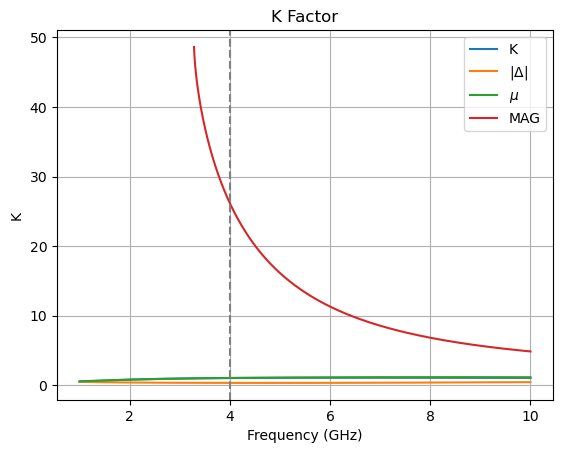

In [157]:
# delta is the determinant of the S-parameter matrix
delta = bjt.s11.s * bjt.s22.s - bjt.s12.s * bjt.s21.s

# k calculation
k = (1 - sqabs(bjt.s11.s) - sqabs(bjt.s22.s) + sqabs(delta)) / \
    (2 * np.abs(bjt.s12.s * bjt.s21.s))

# mu calculation
mu = (1 - sqabs(bjt.s11.s)) / (np.abs(bjt.s22.s -
                                      (delta*np.conj(bjt.s11.s)))+np.abs(bjt.s21.s*bjt.s12.s))

# Maximum available gain (MAG) calculation
MAG = np.abs(bjt.s12.s/bjt.s21.s) * (k-np.sqrt(np.square(k)-1))

k = np.squeeze(k)  # Remove any singleton dimensions
delta = np.squeeze(delta)  # Remove any singleton dimensions
mu = np.squeeze(mu)  # Remove any singleton dimensions
MAG = np.squeeze(MAG)  # Remove any singleton dimensions

# Print MAG at 4 Ghz
val = MAG[np.where(np.isclose(bjt.f, 4e9, atol=1e7))]
print('MAG at 4 GHz:', sum(val)/len(val))

# Plotting k values
plt.figure()
plt.plot(bjt.f/1e9, k)
plt.plot(bjt.f/1e9, np.abs(delta))
plt.plot(bjt.f/1e9, mu)
plt.plot(bjt.f/1e9, MAG)
#add line in 4 Ghz
plt.axvline(x=4, color='gray', linestyle='--')
plt.title('K Factor')
plt.xlabel('Frequency (GHz)')
plt.ylabel('K')
plt.grid()
plt.legend(['K', '|$\\Delta$|', '$\\mu$', 'MAG'])
plt.show()


### Calc $\rho_L$ and $\rho_S$ and $\Z_L$ and $\Z_S$

In [ ]:
# Calcular B1, B2, C1 e C2
print("Frequency (GHz):", bjt.f[freq_idx] / 1e9)
delta4GHz = delta[freq_idx]
print('delta4GHz:', delta4GHz)

# S11 and S22 for 4 GHz
s11 = freq_point.s11.s[0, 0]  
s22 = freq_point.s22.s[0, 0]  
print('S11:', s11)
print('S22:', s22)
print('|s11|: ', np.abs(s11))
print('|s22|: ', np.abs(s22))

B1 = 1 + sqabs(s11) - sqabs(s22) - sqabs(delta4GHz)
print('B1:', B1)
B2 = 1 + sqabs(s22) - sqabs(s11) - sqabs(delta4GHz)
print('B2:', B2)
C1 = s11 - (delta4GHz * np.conj(s22))
print('C1:', C1)
C2 = s22 - (delta4GHz * np.conj(s11))
print('C2:', C2)

# Calcular ros (ρs) e rol (ρL)
ros = (B1 - np.sqrt(np.square(B1) - 4 * sqabs(C1))) / (2 * C1)
rol = (B2 - np.sqrt(np.square(B2) - 4 * sqabs(C2))) / (2 * C2)
print("ros (ρs):", ros)
print("rol (ρL):", rol)
zs = (1 + ros) / (1 - ros)
zl = (1 + rol) / (1 - rol)
print("zs:", zs)
print("zl:", zl)

skplt.plot_smith(zs, smith_r=1, chart_type='z')

Frequency (GHz): 3.99391300976755
delta4GHz: (-0.033221327963681824-0.34631638322807373j)
S11: [-0.34038455+0.27382311j]
S22: [0.06099101-0.17707879j]
|s11|:  [0.43685322]
|s22|:  [0.18728802]
B1: [1.03472524]
B2: [0.72319737]
C1: [-0.39968363+0.30082809j]
C2: [0.14451242-0.3040563j]
ros (ρs): [-0.61551748-0.46327879j]
rol (ρL): [0.29278313+0.61602013j]
zs: [0.14392195-0.32804026j]
zl: [0.60797527+1.4006243j]


NameError: name 'z' is not defined

### Calc matching source and load circuit with Lumped elements in L

In [ ]:

def calc_lumped_matching_circuits(f, z0, rl, xl):
    zl = rl + 1j*xl
    zl = np.conj(zl)
    rl = np.real(zl)
    xl = np.imag(zl)
    if rl > 1: 
        b1 = (xl + (np.sqrt(rl/z0)*np.sqrt(np.square(rl)+np.square(xl)-z0*rl)))/(np.square(rl)+np.square(xl))
        b2 = (xl - (np.sqrt(rl/z0)*np.sqrt(np.square(rl)+np.square(xl)-z0*rl)))/(np.square(rl)+np.square(xl))

        xa = 1/b1 + (xl*z0/rl) - (z0/(b1*rl))
        x1 = xa
        x2 = - xa

        if b1 > 0:
            bmais = b1
            bmenos = b2
        else:
            bmais = b2
            bmenos = b1
        if x1 > 0:
            xmais = x1
            xmenos = x2
        else:
            xmais = x2
            xmenos = x1
        print("------------------------------------")
        print("Z0 - Xserie + Bparalelo - Z")
        print("B+ = ", bmais)
        print("X+ = ", xmais)
        print("B- = ", bmenos)
        print("X- = ", xmenos)
        print("------------------------------------")
        z0 = 50
        L_serie = xmais*z0/(2*np.pi*f)
        C_paralelo = bmais/(2*np.pi*f*z0)
        L_paralelo = -z0/(bmenos*2*np.pi*f)
        C_serie = -1/(z0*xmenos*2*np.pi*f)
        print("L_serie = ", L_serie)
        print("C_paralelo = ", C_paralelo)
        print("L_paralelo = ", L_paralelo)
        print("C_serie = ", C_serie)
        print("------------------------------------")
    else:
        xa = np.sqrt(rl*(z0-rl))
        if (xl<0):
            xmenos = -np.abs(xa - xl)
            xmais = np.abs(-xa - xl)
        else:
            xmenos = -xa - xl
            xmais = xa - xl

        ba = np.sqrt((z0-rl)/rl)/z0
        bmais = ba
        bmenos = -ba

        print("------------------------------------")
        print("Z0 - Bparalelo + Xserie - Z")
        print("X+ = ", xmais)
        print("X- = ", xmenos)
        print("B+ = ", bmais)
        print("B- = ", bmenos)
        print("------------------------------------")
        z0 = 50
        L_serie = xmais*z0/(2*np.pi*f)
        C_paralelo = bmais/(2*np.pi*f*z0)
        L_paralelo = -z0/(bmenos*2*np.pi*f)
        C_serie = -1/(z0*xmenos*2*np.pi*f)
        print("L_serie = ", L_serie)
        print("C_paralelo = ", C_paralelo)
        print("L_paralelo = ", L_paralelo)
        print("C_serie = ", C_serie)
        print("------------------------------------")
    return


f = freq_point.f[0]  
rs = np.real(zs)
xs = np.imag(zs)
rl = np.real(zl)
xl = np.imag(zl)
z0 = 1

print("------------------------------------")
print("Calc source matching circuit")
calc_lumped_matching_circuits(f, z0, rs, xs)
print("------------------------------------")
print("Calc load matching circuit")
calc_lumped_matching_circuits(f, z0, rl, xl)

------------------------------------
Calc source matching circuit
------------------------------------
Z0 - Bparalelo + Xserie - Z
X+ =  [0.02297031]
X- =  [-0.67905083]
B+ =  [2.43889535]
B- =  [-2.43889535]
------------------------------------
L_serie =  [4.57676312e-11]
C_paralelo =  [1.94376918e-12]
L_paralelo =  [8.16955439e-10]
C_serie =  [1.17367875e-12]
------------------------------------
------------------------------------
Calc load matching circuit
------------------------------------
Z0 - Bparalelo + Xserie - Z
X+ =  [0.91242215]
X- =  [-1.88882645]
B+ =  [0.80299672]
B- =  [-0.80299672]
------------------------------------
L_serie =  [1.81797269e-09]
C_paralelo =  [6.39978374e-13]
L_paralelo =  [2.48129135e-09]
C_serie =  [4.21948522e-13]
------------------------------------


### Calc impedance matching with lines and stubs

In [ ]:
def calc_lines_stubs_circuit(z0,zl,f):
    #calc admitance
    y0 = 1/z0
    zl = zl*z0
    zl = np.conj(zl)
    rl = np.real(zl)
    xl = np.imag(zl)
    #shunt stubs
    print("------------------------------------")
    print("Calc shunt stubs")
    print("------------------------------------")
    
    t1 = (xl + np.sqrt(rl*(np.square(z0-rl)+np.square(xl))/z0))/(rl-z0)
    t2 = (xl - np.sqrt(rl*(np.square(z0-rl)+np.square(xl))/z0))/(rl-z0)
    print("t1:", t1)
    print("t2:", t2)

    t = t1
    # G1 = (rl*(1+np.square(t)))/(np.square(rl)+np.square(xl + z0*t))
    # print("G1:", G1)
    B1 = (np.square(rl)*t - (z0-xl*t)*(xl+z0*t))/(z0*(np.square(rl)+np.square(xl+z0*t)))
    print("B1:", B1)
    if t >= 0:
        d = ((1/(2*np.pi)*np.arctan(t)))/f
        if d < 0:
            d = d + 1/(2*f)
        print("d1:", d)
    else:
        d = (1/(2*np.pi)*(np.pi * np.arctan(t)))/f
        if d < 0:
            d = d + 1/(2*f)
        print("d1:", d)

    t = t2
    # G2 = (rl*(1+np.square(t)))/(np.square(rl)+np.square(xl + z0*t))
    # print("G2:", G2)
    B1 = (np.square(rl)*t - (z0-xl*t)*(xl+z0*t))/(z0*(np.square(rl)+np.square(xl+z0*t)))
    print("B2:", B2)
    if t >= 0:
        d = (1/(2*np.pi)*np.arctan(t))/f
        if d < 0:
            d = d + 1/(2*f)
        print("d2:", d)
    else:
        d = (1/(2*np.pi)*(np.pi * np.arctan(t)))/f
        if d < 0:
            d = d + 1/(2*f)
        print("d2:", d)
    
    #open circuit
    print(">>>>>>> Open circuit")
    l1 = (-1/(2*np.pi)*np.arctan(B1/y0))/f
    if l1 < 0:
        l1 = l1 + 1/(2*f)
    print("l1:", l1)
    l2 = (-1/(2*np.pi)*np.arctan(B2/y0))/f
    if l2 < 0:
        l2 = l2 + 1/(2*f)
    print("l2:", l2)
    #short circuit
    print(">>>>>>> Short circuit")
    l1 = (1/(2*np.pi)*np.arctan(y0/B1))/f
    if l1 < 0:
        l1 = l1 + 1/(2*f)
    print("l1:", l1)
    l2 = (1/(2*np.pi)*np.arctan(y0/B2))/f
    if l2 < 0:
        l2 = l2 + 1/(2*f)
    print("l2:", l2)

    # #series stubs
    # print("------------------------------------")
    # print("Calc series stubs")
    # print("------------------------------------")
    # yl = 1/zl
    # gl = np.real(yl)
    # bl = np.imag(yl)
    
    # t1 = (bl + np.sqrt(gl*((np.square(y0-gl)+np.square(bl)))/y0))/(gl-y0)
    # print("t1:", t1)
    # t2 = (bl - np.sqrt(gl*((np.square(y0-gl)+np.square(bl)))/y0))/(gl-y0)
    # print("t2:", t2)

    # t = t1
    # if t >= 0:
    #     d = (1/(2*np.pi)*np.arctan(t))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # else:
    #     d = (1/(2*np.pi)*(np.pi * np.arctan(t)))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # R1 = (gl*(1+np.square(t)))/(np.square(gl)+np.square(bl + y0*t))
    # print("R1:", R1)
    # X1 = (np.square(gl)*t - (y0-bl*t)*(bl+y0*t))/(y0*(np.square(gl)+np.square(bl+y0*t)))
    # print("X1:", X1)

    # t= t2
    # if t >= 0:
    #     d = (1/(2*np.pi)*np.arctan(t))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # else:
    #     d = (1/(2*np.pi)*(np.pi * np.arctan(t)))/f
    #     if d < 0:
    #         d = d + 1/(2*f)
    #     print("d:", d)
    # R2 = (gl*(1+np.square(t)))/(np.square(gl)+np.square(bl + y0*t))
    # print("R2:", R2)
    # X2 = (np.square(gl)*t - (y0-bl*t)*(bl+y0*t))/(y0*(np.square(gl)+np.square(bl+y0*t)))
    # print("X2:", X2)
    # #short circuit
    # print(">>>>>>> Short circuit")
    # l1 = (-1/(2*np.pi)*np.arctan(X1/z0))/f
    # if l1 < 0:
    #     l1 = l1 + 1/(2*f)
    # print("l1:", l1)
    # l2 = (-1/(2*np.pi)*np.arctan(X2/z0))/f
    # if l2 < 0:
    #     l2 = l2 + 1/(2*f)
    # print("l2:", l2)
    # #open circuit
    # print(">>>>>>> Open circuit")
    # l1 = (1/(2*np.pi)*np.arctan(z0/X1))/f
    # if l1 < 0:
    #     l1 = l1 + 1/(2*f)
    # print("l1:", l1)
    # l2 = (1/(2*np.pi)*np.arctan(z0/X2))/f
    # if l2 < 0:
    #     l2 = l2 + 1/(2*f)
    # print("l2:", l2)

print("------------------------------------")
print("Calc source matching circuit")
calc_lines_stubs_circuit(50,zs,f)
print("\n------------------------------------")
print("Calc loud matching circuit")
calc_lines_stubs_circuit(50,zl,f)


------------------------------------
Calc source matching circuit
------------------------------------
Calc shunt stubs
------------------------------------
t1: [-0.78945882]
t2: [0.0230795]
B1: [0.04833149]
d1: [4.15281626e-11]
B2: [0.72319737]
d2: [9.19540323e-13]
>>>>>>> Open circuit
l1: [4.69602071e-11]
l2: [6.36970066e-11]
>>>>>>> Short circuit
l1: [1.09555461e-10]
l2: [1.10175241e-12]

------------------------------------
Calc loud matching circuit
------------------------------------
Calc shunt stubs
------------------------------------
t1: [0.67992517]
t2: [6.46566643]
B1: [0.03730668]
d1: [2.37950783e-11]
B2: [0.72319737]
d2: [5.64804755e-11]
>>>>>>> Open circuit
l1: [4.29851145e-11]
l2: [6.36970066e-11]
>>>>>>> Short circuit
l1: [1.05580369e-10]
l2: [1.10175241e-12]
